In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage
from Bio import SeqIO

In [88]:
def get_segments(aa_seq, label_seq, segment_type, accession, description):
    slices = ndimage.find_objects(ndimage.label(label_seq)[0])
    ds = []
    for s in slices:
        segment = aa_seq[s[0]]  # Unpack 1-element slice tuple
        d = {'accession': accession, 'description': description, 'segment_type': segment_type, 'len': len(segment)}
        aa_counts = count_amino_acids(segment)
        d.update(aa_counts)
        ds.append(d)
    return ds


def count_amino_acids(aa_seq):
    aa_codes = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H',
                'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 
                'Y', 'V', 'O', 'U', 'B', 'Z', 'X', 'J']
    d = {aa: 0 for aa in aa_codes}
    for aa in aa_seq:
        d[aa] += 1
    return d

In [89]:
fasta_seq = SeqIO.parse('../generate_fastas/out/allseq.fasta', 'fasta')
fasta_disorder = SeqIO.parse('../generate_fastas/out/alldisorder.fasta', 'fasta')

In [90]:
protein_seq_dict = {}
for protein in fasta_seq:
    protein_seq_dict[protein.id.split("|")[0]] = str(protein.seq)

In [91]:
rows = []
for protein in fasta_disorder:
    dis_labels = [s == '1' for s in protein.seq]
    ord_labels = [s == '0' for s in protein.seq]

    accession = protein.id.split("|")[0]
    description = protein.description.split("|")[-1]
    aa_seq = protein_seq_dict[accession]
    
    # Disordered regions have the code 'D' and ordered regions have the code 'O'
    # The entire protein is added with the code 'P'
    ds_dis = get_segments(aa_seq, dis_labels, 'D', accession, description)
    ds_ord = get_segments(aa_seq, ord_labels, 'O', accession, description)
    ds_all = get_segments(aa_seq, [True for _ in range(len(aa_seq))], 'P', accession, description)

    # Add ds to rows
    rows.extend(ds_dis)
    rows.extend(ds_ord)
    rows.extend(ds_all)
df1 = pd.DataFrame(rows)
print(df1)

       accession                                        description  \
0         P61926  cAMP-dependent protein kinase inhibitor alpha ...   
1         P61926  cAMP-dependent protein kinase inhibitor alpha ...   
2         Q9KN46  ImpA_N domain-containing protein OS=Vibrio cho...   
3         Q9KN46  ImpA_N domain-containing protein OS=Vibrio cho...   
4         Q9KN46  ImpA_N domain-containing protein OS=Vibrio cho...   
...          ...                                                ...   
188312    O70709  sequence OS=Anomala cuprea entomopoxvirus OX=6...   
188313    O70709  sequence OS=Anomala cuprea entomopoxvirus OX=6...   
188314    O70709  sequence OS=Anomala cuprea entomopoxvirus OX=6...   
188315    O70709  sequence OS=Anomala cuprea entomopoxvirus OX=6...   
188316    O70709  sequence OS=Anomala cuprea entomopoxvirus OX=6...   

       segment_type  len   A   R   N   D   C   Q  ...   T  W   Y   V  O  U  B  \
0                 D   76  10   4   4   5   0   3  ...   6  0   1  

# 1 Length Distributions

In [92]:
## Length Distribution of Protein 

Text(0.5, 1.0, 'Length of Proteins')

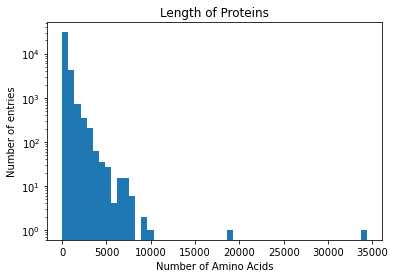

In [93]:
protein = df1[df1['segment_type'] == 'P']
plt.hist(protein['len'], bins=50)
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Number of Amino Acids')
plt.title('Length of Proteins')

### Outliers

In [94]:
print(protein[protein['len'] > 15000])

       accession                                        description  \
75735     G4SLH0  Titin homolog OS=Caenorhabditis elegans OX=623...   
152199    Q8WZ42       Titin OS=Homo sapiens (Human) OX=9606 GN=TTN   

       segment_type    len     A     R     N     D    C    Q  ...     T    W  \
75735             P  18562  1419   505   600  1312  177  856  ...  1265   96   
152199            P  34350  2084  1640  1111  1720  513  942  ...  2546  466   

          Y     V  O  U  B  Z  X  J  
75735   231  1525  0  0  0  0  0  0  
152199  999  3184  0  0  0  0  0  0  

[2 rows x 30 columns]


## Length Distribution of Proteins After Removing Outliers

Text(0.5, 1.0, 'Length of Proteins')

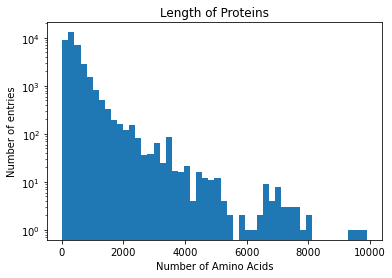

In [95]:
protein_outrm =  protein[protein['len'] < 15000]
plt.hist(protein_outrm['len'], bins=50)
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Number of Amino Acids')
plt.title('Length of Proteins')

## Length Distribution of Disordered Regions

Text(0.5, 1.0, 'Length of Disordered Regions')

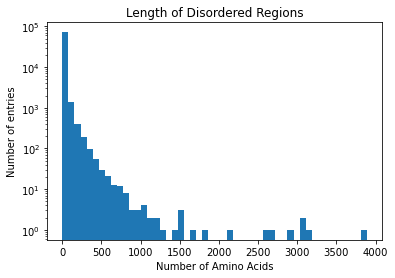

In [96]:
disorder = df1[df1['segment_type'] == 'D']
plt.hist(disorder['len'], bins=50)
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Number of Amino Acids')
plt.title('Length of Disordered Regions')

## Length Distribution of Ordered Regions

Text(0.5, 1.0, 'Length of Ordered Regions')

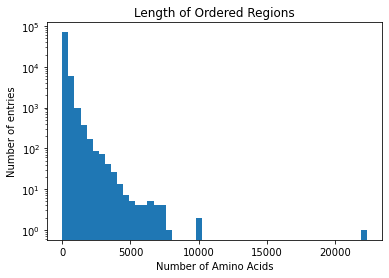

In [97]:
order = df1[df1['segment_type'] == 'O']
plt.hist(order['len'], bins=50)
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Number of Amino Acids')
plt.title('Length of Ordered Regions')

### Outliers 

In [98]:
order[order['len'] > 15000]

,accession,description,segment_type,len,A,R,N,D,C,Q,...,T,W,Y,V,O,U,B,Z,X,J
152198,Q8WZ42,Titin OS=Homo sapiens (Human) OX=9606 GN=TTN,O,22319,1310,1184,788,1238,300,520,...,1739,365,704,2004,0,0,0,0,0,0


In [99]:
df1[df1['accession'] == 'Q8WZ42']

,accession,description,segment_type,len,A,R,N,D,C,Q,...,T,W,Y,V,O,U,B,Z,X,J
152196,Q8WZ42,Titin OS=Homo sapiens (Human) OX=9606 GN=TTN,D,2152,129,62,0,11,0,28,...,54,3,32,329,0,0,0,0,0,0
152197,Q8WZ42,Titin OS=Homo sapiens (Human) OX=9606 GN=TTN,O,9879,645,394,323,471,213,394,...,753,98,263,851,0,0,0,0,0,0
152198,Q8WZ42,Titin OS=Homo sapiens (Human) OX=9606 GN=TTN,O,22319,1310,1184,788,1238,300,520,...,1739,365,704,2004,0,0,0,0,0,0
152199,Q8WZ42,Titin OS=Homo sapiens (Human) OX=9606 GN=TTN,P,34350,2084,1640,1111,1720,513,942,...,2546,466,999,3184,0,0,0,0,0,0


# 2 Fraction disordered distribution

Text(0.5, 1.0, 'Fraction Disordered Distribution')

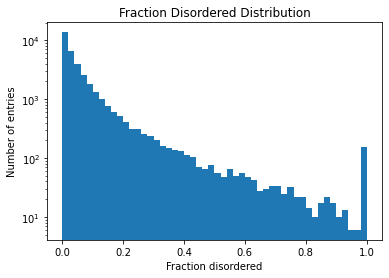

In [100]:
disorder_lengths = disorder.groupby('accession')['len'].sum().rename('D_len')
df2 = protein[['accession', 'len']].merge(disorder_lengths, on='accession', how='left').fillna(0)
df2['D_frac'] = df2['D_len'] / df2['len']

plt.hist(df2['D_frac'], bins=50)
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Fraction disordered')
plt.title('Fraction Disordered Distribution')

# 3 Fraction ordered distribution

Text(0.5, 1.0, 'Fraction Ordered Distribution')

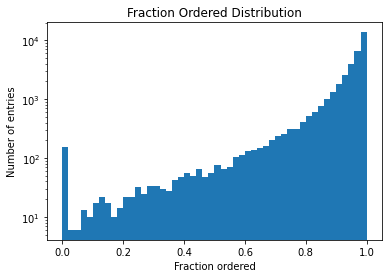

In [101]:
order_lengths = order.groupby('accession')['len'].sum().rename('O_len')
df2 = df2.merge(order_lengths, on='accession', how='left').fillna(0)
df2['O_frac'] = df2['O_len'] / df2['len']

plt.hist(df2['O_frac'], bins=50)
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Fraction ordered')
plt.title('Fraction Ordered Distribution')

# 4 Correlation of fraction disordered with number of disordered segments

## 2D Histogram

Text(0.5, 1.0, 'Number Disordered Regions vs. Disordered Content')

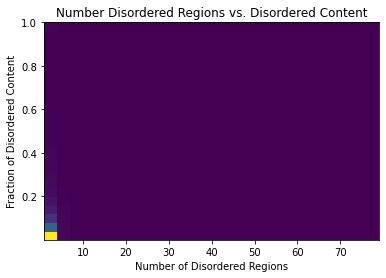

In [102]:
D_segnum = disorder.groupby('accession').size().rename('D_segnum')
df2 = df2.merge(D_segnum, on='accession', how='left').fillna(0)

plt.hist2d(df2['D_segnum'], df2['D_frac'], bins=25)
plt.ylabel('Fraction of Disordered Content')
plt.xlabel('Number of Disordered Regions')
plt.title('Number Disordered Regions vs. Disordered Content')

## Scatter plot

Text(0.5, 1.0, 'Number Disordered Regions vs. Disordered Content')

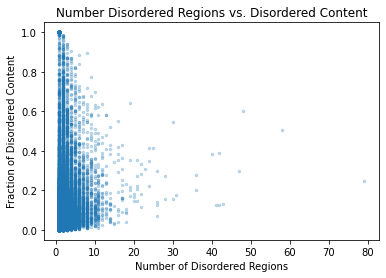

In [103]:
plt.scatter(df2['D_segnum'], df2['D_frac'], s=6, alpha=0.25)
plt.ylabel('Fraction of Disordered Content')
plt.xlabel('Number of Disordered Regions')
plt.title('Number Disordered Regions vs. Disordered Content')

### Outliers

In [104]:
df2[df2['D_segnum'] > 50]

,accession,len,D_len,D_frac,O_len,O_frac,D_segnum
4972,Q8CIE6,1224,620,0.506536,604.0,0.493464,58
26795,O94248,4717,1177,0.249523,3540.0,0.750477,79


In [105]:
df1[df1['accession'] == 'O94248']

,accession,description,segment_type,len,A,R,N,D,C,Q,...,T,W,Y,V,O,U,B,Z,X,J
138411,O94248,Midasin OS=Schizosaccharomyces pombe (strain 9...,D,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
138412,O94248,Midasin OS=Schizosaccharomyces pombe (strain 9...,D,4,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
138413,O94248,Midasin OS=Schizosaccharomyces pombe (strain 9...,D,4,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
138414,O94248,Midasin OS=Schizosaccharomyces pombe (strain 9...,D,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
138415,O94248,Midasin OS=Schizosaccharomyces pombe (strain 9...,D,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138564,O94248,Midasin OS=Schizosaccharomyces pombe (strain 9...,O,23,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
138565,O94248,Midasin OS=Schizosaccharomyces pombe (strain 9...,O,45,1,3,1,3,2,3,...,1,0,2,2,0,0,0,0,0,0
138566,O94248,Midasin OS=Schizosaccharomyces pombe (strain 9...,O,128,5,3,11,5,3,3,...,5,0,1,7,0,0,0,0,0,0
138567,O94248,Midasin OS=Schizosaccharomyces pombe (strain 9...,O,214,12,8,8,15,2,13,...,10,1,7,14,0,0,0,0,0,0


## Scatter plot without Outliers 

Text(0.5, 1.0, 'Number Disordered Regions vs. Disordered Content')

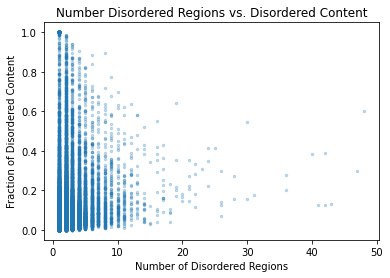

In [106]:
df2_outrm = df2[df2['D_segnum'] < 50]
plt.scatter(df2_outrm['D_segnum'], df2_outrm['D_frac'], s=6, alpha=0.25)
plt.ylabel('Fraction of Disordered Content')
plt.xlabel('Number of Disordered Regions')
plt.title('Number Disordered Regions vs. Disordered Content')

## Correlation Coefficient

In [107]:
correlation = df2_outrm['D_segnum'].corr(df2_outrm['D_frac'])
correlation

0.19250026669773024

# 5 Correlation of average length of disordered segments with number of disordered segments

## 2D Histogram 

Text(0.5, 1.0, 'Average Length of Disordered Content vs. Number of Disordered Regions')

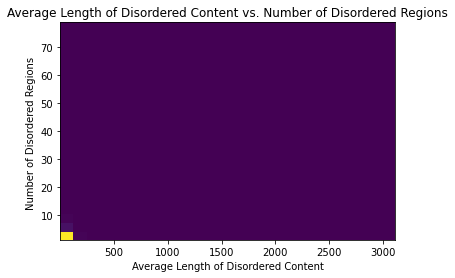

In [108]:
df3 = disorder[['accession', 'len']].groupby('accession').mean().merge(D_segnum, on='accession')
plt.hist2d(df3['len'], df3['D_segnum'], bins=25)
plt.ylabel('Number of Disordered Regions ')
plt.xlabel('Average Length of Disordered Content')
plt.title('Average Length of Disordered Content vs. Number of Disordered Regions')

## Scatter plot

Text(0.5, 1.0, 'Number of Disordered Regions vs. Average Length of Disordered Regions')

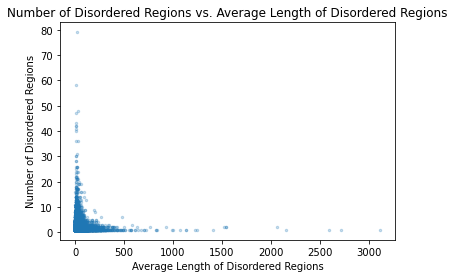

In [109]:
plt.scatter(df3['len'], df3['D_segnum'], s=6, alpha=0.25)
plt.ylabel('Number of Disordered Regions')
plt.xlabel('Average Length of Disordered Regions')
plt.title('Number of Disordered Regions vs. Average Length of Disordered Regions')

## Scatter plot without outliers

Text(0.5, 1.0, 'Number of Disordered Regions vs. Average Length of Disordered Regions')

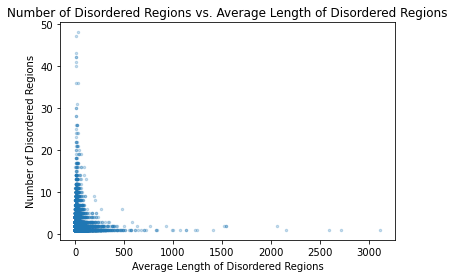

In [110]:
df3_outrm = df3[df3['D_segnum'] < 50]
plt.scatter(df3_outrm['len'], df3_outrm['D_segnum'], s=6, alpha=0.25)
plt.ylabel('Number of Disordered Regions')
plt.xlabel('Average Length of Disordered Regions')
plt.title('Number of Disordered Regions vs. Average Length of Disordered Regions')

# 6 Number disordered segments in proteins distribution

Text(0.5, 1.0, 'Number of Disordered Segments Distribution')

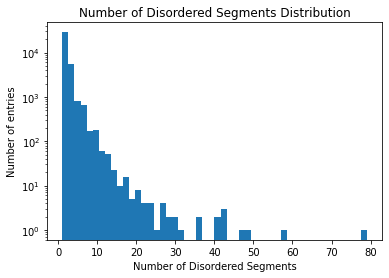

In [111]:
plt.hist(df2['D_segnum'], bins=50)
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Number of Disordered Segments')
plt.title('Number of Disordered Segments Distribution')

### Outliers

In [112]:
df2[df2['D_segnum'] > 60]

,accession,len,D_len,D_frac,O_len,O_frac,D_segnum
26795,O94248,4717,1177,0.249523,3540.0,0.750477,79


Text(0.5, 1.0, 'Number of Disordered Segments Distribution')

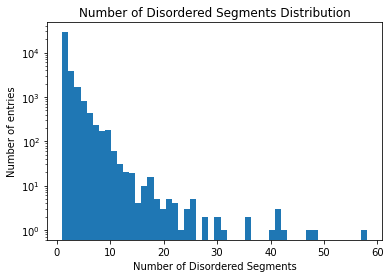

In [113]:
plt.hist(df2.loc[df2['D_segnum'] < 60, 'D_segnum'], bins=50)
plt.yscale('log')
plt.ylabel('Number of entries')
plt.xlabel('Number of Disordered Segments')
plt.title('Number of Disordered Segments Distribution')

# 7 Amino acid distributions and enrichment 

## Disordered Segments 

In [114]:
aa_codes = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H',
            'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 
            'Y', 'V', 'O', 'U', 'B', 'Z', 'X', 'J']

Text(0.5, 1.0, 'Disordered Region Amino Acid Distribution')

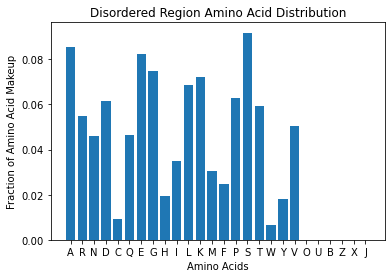

In [115]:
aa_counts_dis = df.loc[df['segment_type'] == 'D', aa_codes].sum()
aa_fracs_dis = aa_counts_dis /aa_counts_dis.sum()
plt.bar(aa_codes, aa_fracs_dis)
plt.ylabel('Fraction of Amino Acid Makeup')
plt.xlabel('Amino Acids')
plt.title('Disordered Region Amino Acid Distribution')

Text(0.5, 1.0, 'Total Amino Acid Distribution')

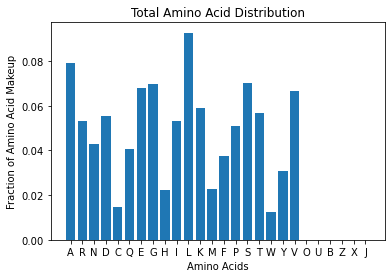

In [116]:
aa_counts = df.loc[df['segment_type'] == 'P', aa_codes].sum()
aa_fracs = aa_counts / aa_counts.sum()
plt.bar(aa_codes, aa_fracs)
plt.ylabel('Fraction of Amino Acid Makeup')
plt.xlabel('Amino Acids')
plt.title('Total Amino Acid Distribution')

Text(0.5, 1.0, 'Difference of Protein and Disordered Segments Amino Acid Distribution')

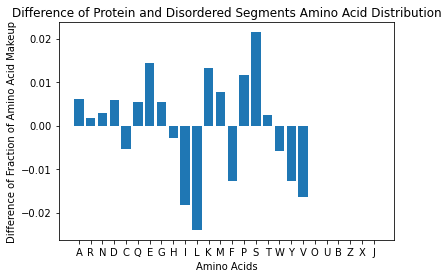

In [117]:
aa_fracs_dif = aa_fracs_dis - aa_fracs
plt.bar(aa_codes, aa_fracs_dif)
plt.ylabel('Difference of Fraction of Amino Acid Makeup')
plt.xlabel('Amino Acids')
plt.title('Difference of Protein and Disordered Segments Amino Acid Distribution')

## Overlay Bar Chart Amino Acid Distributions over Proteins vs. Disordered Segments

In [118]:
def overlapped_bar(df, show=False, width=0.9, alpha=.5,
                   title='', xlabel='', ylabel='', **plot_kwargs):
    """
    Like a stacked bar chart except bars on top of each other with transparency
    
    source: https://stackoverflow.com/questions/23293011/how-to-plot-a-superimposed-bar-chart-using-matplotlib-in-python"
    """
    xlabel = xlabel or df.index.name
    N = len(df)
    M = len(df.columns)
    indices = np.arange(N)
    colors = ['steelblue', 'firebrick', 'darksage', 'goldenrod', 'gray'] * int(M / 5. + 1)
    for i, label, color in zip(range(M), df.columns, colors):
        kwargs = plot_kwargs
        kwargs.update({'color': color, 'label': label})
        plt.bar(indices, df[label], width=width, alpha=alpha if i else 1, **kwargs)
        plt.xticks(indices + 0.5 * width, ['{}'.format(idx) for idx in df.index.values])
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if show:
        plt.show()
    return plt.gcf()

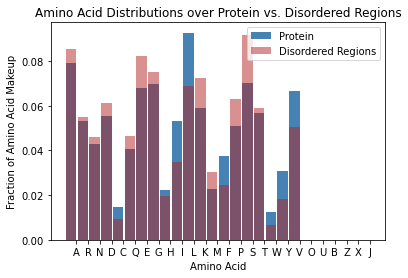

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [119]:
df_overlap_bar = pd.DataFrame(np.matrix([aa_fracs, aa_fracs_dis]).T, columns=['Protein', 'Disordered Regions'],
                              index=pd.Index(aa_codes))
overlapped_bar(df_overlap_bar, show=True, title='Amino Acid Distributions over Protein vs. Disordered Regions',
               xlabel='Amino Acid', ylabel='Fraction of Amino Acid Makeup')